In [1]:
# from tqdm import tqdm
from tqdm import tqdm

from itertools import chain

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

from codes.dataset.dataset_batcher import SlimDataset
from codes.models.SLIM import SLIM
from codes.utils.utils import seed_everything, load_config_file
from codes.utils.gpu_cuda_helper import select_device


In [2]:
config_path = "codes/config.json"
project_dir = "/srv/data/zarzouram/lt2318"
dataset_dir = f"{project_dir}/slim/turk_torch/test"
model_dir = f"{project_dir}/checkpoints/0809.1526"

vocab_path = f"{model_dir}/vocab.pt"
model_path = f"{model_dir}/checkpoint_best.pt"

In [3]:
configs = load_config_file(config_path)

In [4]:
seed = configs["seed"]
seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)

 ### Initialize some variables


In [5]:
vocab_specials = {"pad": "<pad>", "eos": "<eos>", "unk": "<unk>"}
pretrain = None
model_parameters = configs["model_hyperparameter"]
configs_glove = configs["glove"]
config_loader = configs["dataloader"]

 ### Auotomatic GPU selection

In [6]:
device = select_device("gpu")
print(f"selected device is {device}.")


 cuda id   Memory usage  
    0          0.00%     
    1          0.00%     
    2          0.00%     
    3          0.00%     
selected device is cuda:3.


 ### DataLoader

In [7]:
test_ds = SlimDataset(root_dir=dataset_dir,
                      pretrain=pretrain,
                      glove_name=configs_glove["name"],
                      glove_dir=configs_glove["dir"],
                      glove_dim=configs_glove["dim"],
                      vocab_specials=vocab_specials,
                      vocab_path=vocab_path)

In [8]:
vocab = test_ds.vocab  # vocabulary for the train split
pad_value = test_ds.pad_value

# For each context (an image and its camera viewpoint) construct the other 9
# camera angels and the natural language description
images = torch.as_tensor(test_ds.images, dtype=torch.float)
views = torch.as_tensor(test_ds.views, dtype=torch.float)
tokens = pad_sequence(chain.from_iterable(test_ds.tokens),
                      padding_value=pad_value,
                      batch_first=True).view(*images.size()[:2], -1)
lengthes = torch.as_tensor(list(chain.from_iterable(test_ds.lengths)),
                           dtype=torch.long).view(*images.size()[:2], -1)

# indices for the other information.
# For each scene: there are (n=10) images.
# For each image m_i, where  1 ≥ i ≤ n and i ∈ ℕ there are nine (n-1) textual
# descriptions t_j and viewpoints v_j, where j ∈ ℕ, {1 ≥ j ≤ n | j ≠ i}
b, n, c, h, w = images.size()
j = [i for j in range(n) for i in range(n) if i != j]  # indices j
views_other = views[:, j, :].view(-1, n - 1, views.size(-1))
tokens_other = tokens[:, j, :].view(-1, n - 1, tokens.size(-1))
lengthes_other = lengthes[:, j, :].view(-1, n - 1)

images = images.view(-1, c, h, w)  # (b*n, c, h, w)
views = views.view(-1, views.size(-1))

test_iter = list(zip(images, views, views_other, tokens_other, lengthes_other))
test_iter_len = images.size(0)

### Calculate images std variance

In [9]:
train_ds = SlimDataset(root_dir=f"{project_dir}/slim/turk_torch/train",
                       pretrain=pretrain,
                       glove_name=configs_glove["name"],
                       glove_dir=configs_glove["dir"],
                       glove_dim=configs_glove["dim"],
                       vocab_specials=vocab_specials,
                       vocab_path=vocab_path)


In [10]:
# calc mean and std
images = torch.as_tensor(train_ds.images, dtype=torch.float)
nimages = images.size(0)

# Rearrange shape to be the shape of [B*N, C * W * H]
images = images.view(images.size(0) * images.size(1), -1)
var = images.var(-1).sum(0) / nimages

 ### Construct the model

 ### Load the best model

In [11]:
model_parameters["vocab_size"] = len(test_ds.vocab)
model_inference = SLIM(model_parameters)
model_inference = model_inference.to(device)

model_data = torch.load(model_path, map_location=device)
model_state_dict = model_data["model_state"]
model_inference.load_state_dict(model_state_dict)

<All keys matched successfully>

### Tesing Model

In [2]:
from pathlib import Path
import pandas as pd

retest = False
save_data = Path(f"{project_dir}/test_outputs/inference_outputs_1.pt")
if save_data.is_file() and not retest:
    data_dict = torch.load(save_data)
else:
    model_inference.eval()
    test_loss = []
    images_r = []
    images_g = []
    images_t = []
    tokens_o = []
    view_image = []
    views_o = []

    with tqdm(test_iter, unit="image", total=test_iter_len) as testpb:
        for batch in testpb:
            with torch.no_grad():
                batch_device = [b.to(device).unsqueeze(0) for b in batch]
                batch_device[-2] = batch_device[-2][:, :, :batch[-1].max()]
                image, kl, nll, _ = model_inference(batch_device, var)
                image_g, _ = model_inference.generate(batch_device)

                # save data
                images_r.append(image.cpu())  # reconstructed image
                images_g.append(image_g.cpu())  # generated image
                images_t.append(batch[0])  # ground truth image
                view_image.append(batch[1])
                views_o.append(batch[2])
                tokens_o.append(batch[-2])

                test_loss.append((kl + nll).item())

    data_dict = {
        "GroundTruth": images_t,
        "ImageGen": images_g,
        "ImageRecon": images_r,
        "ImageView": view_image,
        "SceneViews": views_o,
        "tokens_id": tokens_o,
        "loss": test_loss
    }
    torch.save(data_dict, save_data)

In [3]:
test_df = pd.DataFrame(data_dict)

### Loss Calculation

In [15]:
import numpy as np

# test_loss = np.array(test_df.loss)
test_loss = np.array(data_dict["loss"])
loss_average = np.mean(test_loss)
loss_res = np.std(test_loss)
max_loss = np.max(test_loss)
min_loss = np.min(test_loss)

print(f"test loss:         {loss_average:.2f} \u00B1 {loss_res:0.2f}")
print(f"minimum test loss: {min_loss:.3f}")
print(f"maximum test loss: {max_loss:.3f}")

test loss:         1352.39 ± 134.36
minimum test loss: 1037.365
maximum test loss: 2025.424


### PLot Images

In [4]:
from typing import List
from torch import Tensor
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.utils import make_grid
import tensorflow as tf


def resize_images(images: Tensor) -> Tensor:
    """Resizes images with `_IMAGE_SCALE` ratio."""

    images = torch.squeeze(images.permute(0, 2, 3, 1)).numpy()
    images = tf.convert_to_tensor(images)
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    old_size = tf.shape(images)[1:3]
    new_size = tf.cast(tf.cast(old_size, tf.float32) * 4, tf.int32)
    images = tf.image.resize(images, new_size, preserve_aspect_ratio=True)
    images = images.numpy().transpose(0, 3, 1, 2)
    images = torch.as_tensor(images, dtype=torch.float)
    return images


def plot_grid(df: pd.DataFrame):
    plt.figure(figsize=(10, 7))

    plt.subplot(311)
    img = resize_images(torch.squeeze(torch.stack(df.GroundTruth.tolist())))
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid)
    plt.title("Ground Truth")

    plt.subplot(312)
    img = resize_images(torch.squeeze(torch.stack(df.ImageRecon.tolist())))
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Reconstructed")

    plt.subplot(313)
    img = resize_images(torch.squeeze(torch.stack(df.ImageGen.tolist())))
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Generated")

    plt.tight_layout()
    plt.show()

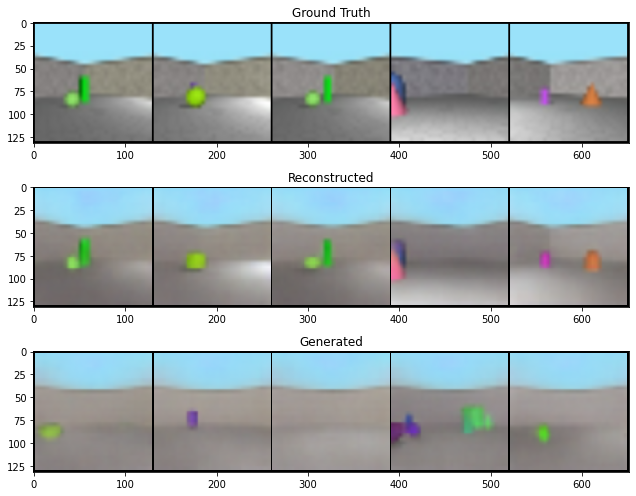

In [5]:
best_samples_df = test_df.nsmallest(5, 'loss', keep='all')
plot_grid(best_samples_df)


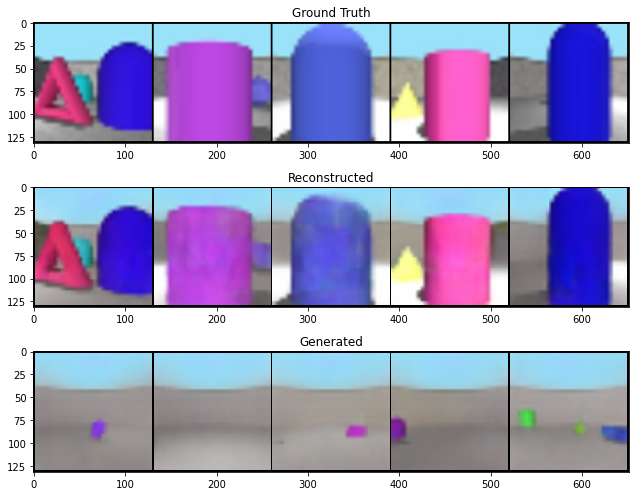

In [6]:
worst_samples_df = test_df.nlargest(5, 'loss', keep='all')
plot_grid(worst_samples_df)